In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath("Forcasting_Models"))
import utils.preprocess as preprocess
import utils.DatasetAccess as DatAccess

In [33]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py


# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
class DatabaseConnection:
    def __init__(self):
        self.conn = self.connect()
    def connect(self):
        try:
            self.conn = pg.connect(
                "dbname='stonksdb' user='postgres' host='localhost' password='admin'")
            print("Connection made succ")
            return self.conn
        except:
            print("I am unable to connect to the database")
            return None
    def close(self):
        self.conn.close()
    
    def GetConnector(self):
        return self.conn
    ### send query to database
    def query(self, query):
        cur = self.conn.cursor()
        cur.execute(query)
        return cur.fetchall()

class DatasetAccess:
    def __init__(self):
        self.conn = DatabaseConnection()
    def getNcompanies(self, N):
        AllCompanies = self.conn.query("SELECT * FROM dataset limit "+ str(N)+"")
        return AllCompanies
    def getStockFromSymbol(self, StockSymbol, column = '*'):
        company = self.conn.query("SELECT * FROM dataset WHERE symbol = '" + StockSymbol + "'")
        self.getStockFromCompany(company, column)
        return company
    def getStockFromCompany(self, companies, column = '*'):
        result = []
        for company in companies:
            result.append(self.conn.query("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "'"))
        return result
    def convertListToString(self, column):
        if type(column) != list:
            return column
        result = ''
        for item in column:
            result += item + ', '
        return result[:-2]
    def getStockDFFromCompany(self, companies, column = '*'):
        result = []
        print(companies)
        for company in companies:
            result.append(pd.read_sql("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "' order by time asc", self.conn.GetConnector()))
        return result
    def GetAllStocksAsDF(self):
        PandaStock = pd.read_sql('SELECT * FROM stock', self.conn.GetConnector())
        print(PandaStock)
    
def GetDF():
    dbaccess = DatasetAccess()
    vestas = pd.read_sql("select * from stock where identifier = 15611 ", dbaccess.conn.GetConnector())
    return vestas

def GetSingleStockDF():
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(2)
    return dbAccess.getStockDFFromCompany(comp, column="close")

def GetStocks(n):
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(n)
    return dbAccess.getStockDFFromCompany(comp, column="close")

def GetStocksHourly(n):
    dbAccess = DatasetAccess()
    comps = dbAccess.getNcompanies(n)
    result = []
    for comp in comps:
        result.append(DatAccess.get_data_for_datasetid(str(comp[0]),dbAccess.conn.GetConnector(),"h")["close"])
    return result
test = GetStocksHourly(10)

Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

In [34]:
test

[0        4832.0
 1        4866.0
 2        4956.0
 3        4924.0
 4        4934.0
          ...   
 4004    21640.0
 4005    21760.0
 4006    21760.0
 4007    21500.0
 4008    21560.0
 Name: close, Length: 4009, dtype: float64,
 0        5200.0
 1        5264.0
 2        5344.0
 3        5296.0
 4        5304.0
          ...   
 4005    22340.0
 4006    22460.0
 4007    22520.0
 4008    22170.0
 4009    22330.0
 Name: close, Length: 4010, dtype: float64,
 0       168.80
 1       167.85
 2       168.65
 3       167.50
 4       167.95
          ...  
 4003     96.84
 4004     97.62
 4005     97.36
 4006     95.72
 4007     96.30
 Name: close, Length: 4008, dtype: float64,
 0       110.00
 1       112.25
 2       110.65
 3       109.45
 4       109.90
          ...  
 4003    167.00
 4004    167.40
 4005    169.55
 4006    168.30
 4007    166.80
 Name: close, Length: 4008, dtype: float64,
 0        72.46
 1        73.36
 2        72.88
 3        74.38
 4        74.20
          ...  
 4

with grouped as (select
    (mod(id, 60) + id)/60 as id_group,
	close,
    high,
    low,
    open
from stock
where identifier = 15611 order by time asc)

select 
	max(high),
	min(low),
	(select close from (select close, id_group from grouped) as closer where closer.id_group = grouped.id_group limit 1),
	(select open from (select open, id_group from grouped order by id_group desc) as closer where closer.id_group = grouped.id_group limit 1)
from grouped
group by id_group

In [12]:
def make_batch():
    replica_input = train
    replica_input = [np.array(replica_input)]
    replica_Input = [n for n in replica_input[0]]
    print("____________-")
    replica_output = train
    replica_output = [np.array(replica_output)]
    replica_Output = [n for n in replica_output[0]]
    print("____________-")
    replica_target = target
    replica_target = [np.array(replica_target)]
    replica_Target = [n for n in replica_target[0]]
    
    #input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]] # takes the number and one hot encodes it
    #print(input_batch)
    #print(replica_Output)
    #output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]] # takes the number and one hot encodes it
    #target_batch = [[word_dict[n] for n in sentences[2].split()]] # takes the number
    # print(input_batch)
    # print([np.array([replica_input])])
    # make tensor
    # return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
    return torch.FloatTensor(replica_Input), torch.FloatTensor(replica_Output), torch.FloatTensor(replica_Target)

In [13]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])
        dec_outputs, hidden = self.dec_cell(dec_inputs, hidden)

        enc_outputs = enc_outputs.transpose(0, 1)
        dec_outputs = dec_outputs.transpose(0, 1)
        enc_outputs = self.attn(enc_outputs)

        attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs.transpose(1,2)), dim=-1)
        context = torch.bmm(attention_weights, enc_outputs)

        # dec_output : batch_size, n_step, n_hidden
        # context: batch_size, n_step, n_hidden
        # combine: batch_size, n_step, 2 * n_hidden
        combine = torch.cat((dec_outputs, context), 2)
        
        return self.out(combine), trained_attn




        # make model shape [n_step, n_class]
        #return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
    
        return score #torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [35]:
from itertools import islice

def window1(seq, n=2):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def getBigData():
    stocks = []
    for stock in GetStocksHourly(10):
        stocks.append(np.array(stock[:5000]).flatten())
    
    WindowedStocks = []
    for stock in stocks:
        WindowedStocks.append(window1(stock, PointSize))

    result = []
    for window in WindowedStocks:
        for i in window:
            result.append(i)

    return result

def getData():
    a = np.array(GetSingleStockDF()[1][:10000]).flatten()
    b = np.array(GetSingleStockDF()[0][:10000]).flatten()

    bop = [a,b]
    result = []
    for i in bop:
        result.append(window1(i,PointSize))
    actual = []
    for it in result:
        for window in it:
            actual.append(window)
    return actual
bd = getBigData()


Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

In [ ]:
# for i in bd:
#     print(i[1])
[i for i in bd]

[(4798.0,
  4832.0,
  4820.0,
  4820.0,
  4818.0,
  4814.0,
  4814.0,
  4822.0,
  4832.0,
  4826.0,
  4836.0,
  4838.0,
  4846.0,
  4832.0,
  4834.0,
  4838.0,
  4840.0,
  4844.0,
  4844.0,
  4860.0,
  4848.0,
  4860.0,
  4862.0,
  4870.0,
  4864.0,
  4856.0,
  4856.0,
  4858.0,
  4846.0,
  4860.0,
  4854.0,
  4854.0,
  4860.0,
  4858.0,
  4848.0,
  4846.0,
  4836.0,
  4856.0,
  4854.0,
  4848.0,
  4858.0,
  4838.0,
  4848.0,
  4858.0,
  4864.0,
  4866.0,
  4874.0,
  4876.0,
  4882.0,
  4876.0,
  4888.0,
  4886.0,
  4888.0,
  4868.0,
  4862.0,
  4850.0,
  4864.0,
  4878.0,
  4870.0,
  4872.0,
  4884.0,
  4888.0,
  4894.0,
  4900.0,
  4874.0,
  4884.0,
  4892.0,
  4900.0,
  4916.0,
  4926.0,
  4940.0,
  4930.0,
  4922.0,
  4918.0,
  4928.0,
  4948.0,
  4938.0,
  4952.0,
  4962.0,
  4966.0,
  4962.0,
  4966.0,
  4948.0,
  4942.0,
  4954.0,
  4962.0,
  4946.0,
  4938.0,
  4944.0,
  4926.0,
  4926.0,
  4930.0,
  4928.0,
  4940.0,
  4956.0,
  4942.0,
  4952.0,
  4952.0,
  4956.0,
  4960.0),

In [36]:
if __name__ == '__main__':
    n_step = 50 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell
    n_class = 1
    PointSize = 100
    closingData = np.array(getBigData())
    print("CD", np.array(cd))
    print("BD", closingData)
    closingData = (closingData - closingData.mean()) / closingData.std()
    train = [d[:50] for d in closingData]
    target = [d[50:] for d in closingData]
    dataset_iter = iter(zip(train, target))
    batch_size = 32
    num_layers = 1

    #use pytorch to create the batches
    dtloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(np.array(train)).float(), torch.from_numpy(np.array(target)).float()),
                                           batch_size=batch_size, shuffle=True, drop_last=True)
    #dtloader = torch.dataloader((train,target), batch_size=batch_size, shuffle=True)

    hidden = torch.zeros(num_layers, batch_size, n_hidden)

    model = Attention()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()
    input_batch = input_batch.unsqueeze(-1)
    output_batch = output_batch.unsqueeze(-1)
    target_batch = target_batch.unsqueeze(-1)

    print(input_batch.shape)
    #print(input_batch)
    
    # Train
    model.train()
    for epoch in range(200):
        for x, y in dtloader:
            optimizer.zero_grad()
            x = x.unsqueeze(-1)
            y = y.unsqueeze(-1)
            output, _ = model(x, hidden, x)
            loss = criterion(output, y.squeeze(0))

        if (epoch + 1) % 5 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'MSE =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()
    #2m 30 sec for 2000 points
    #


Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

CD [[5170. 5200. 5192. ... 5360. 5348. 5360.]
 [5200. 5192. 5200. ... 5348. 5360. 5352.]
 [5192. 5200. 5202. ... 5360. 5352. 5362.]
 ...
 [6025. 6035. 6025. ... 6170. 6170. 6170.]
 [6035. 6025. 6030. ... 6170. 6170. 6170.]
 [6025. 6030. 6030. ... 6170. 6170. 6175.]]
BD [[4832.  4866.  4956.  ... 6110.  6125.  6105. ]
 [4866.  4956.  4924.  ... 6125.  6105.  6120. ]
 [4956.  4924.  4934.  ... 6105.  6120.  6130. ]
 ...
 [ 819.8  821.   828.4 ...  779.4  775.2  777. ]
 [ 821.   828.4  835.  ...  775.2  777.   780.8]
 [ 828.4  835.   849.2 ...  777.   780.8  793.4]]


C:\Users\Jeppe\Stonk\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


____________-
____________-


C:\Users\Jeppe\AppData\Local\Temp\ipykernel_11032\3534468630.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  return torch.FloatTensor(replica_Input), torch.FloatTensor(replica_Output), torch.FloatTensor(replica_Target)


torch.Size([37931, 50, 1])
Epoch: 0005 MSE = 0.851418
Epoch: 0010 MSE = 0.139739
Epoch: 0015 MSE = 0.038911
Epoch: 0020 MSE = 0.024403
Epoch: 0025 MSE = 0.016029
Epoch: 0030 MSE = 0.006268
Epoch: 0035 MSE = 0.007461
Epoch: 0040 MSE = 0.003229
Epoch: 0045 MSE = 0.003610
Epoch: 0050 MSE = 0.004571
Epoch: 0055 MSE = 0.001620
Epoch: 0060 MSE = 0.015098
Epoch: 0065 MSE = 0.003182
Epoch: 0070 MSE = 0.001028
Epoch: 0075 MSE = 0.003140
Epoch: 0080 MSE = 0.002299
Epoch: 0085 MSE = 0.001486
Epoch: 0090 MSE = 0.014064
Epoch: 0095 MSE = 0.007095
Epoch: 0100 MSE = 0.000856
Epoch: 0105 MSE = 0.001677
Epoch: 0110 MSE = 0.000483
Epoch: 0115 MSE = 0.005460
Epoch: 0120 MSE = 0.000883
Epoch: 0125 MSE = 0.002228
Epoch: 0130 MSE = 0.005852
Epoch: 0135 MSE = 0.014351
Epoch: 0140 MSE = 0.006985
Epoch: 0145 MSE = 0.002089
Epoch: 0150 MSE = 0.002123
Epoch: 0155 MSE = 0.007440
Epoch: 0160 MSE = 0.002480
Epoch: 0165 MSE = 0.004157
Epoch: 0170 MSE = 0.004601
Epoch: 0175 MSE = 0.006694
Epoch: 0180 MSE = 0.001390
E

In [ ]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([19802, 50, 1]),
 torch.Size([19802, 50, 1]),
 torch.Size([19802, 50, 1]))

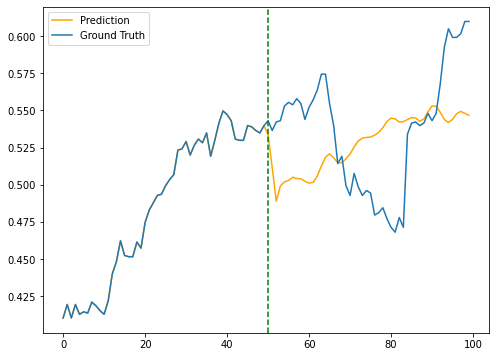

In [50]:
idx = 260

# plot graph
y_ground = np.concatenate((input_batch[idx].reshape(-1), target_batch[idx].reshape(-1)), 0)
model.eval()
hidden = torch.zeros(num_layers, 1, n_hidden)
y_pred = model(input_batch[idx].unsqueeze(0), hidden, input_batch[idx].unsqueeze(0))[0].detach().numpy().reshape(-1) 
y_pred = np.concatenate((input_batch[idx].reshape(-1), y_pred), 0)

# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_pred, label='Prediction', c="orange")
ax.plot(y_ground, label='Ground Truth')
# plt add v line at 50 
ax.axvline(50, color='green', linestyle='--')
ax.legend()
plt.show()

Connection made succ
[(6043, 'Stock', 'DKK', 'A.P. Møller - Mærsk A A/S', 'CSE', '895', 'DK', '6043', 'Instrument', 'MAERSKa:xcse', 'UNKNOWN'), (6041, 'Stock', 'DKK', 'A.P. Møller - Mærsk B A/S', 'CSE', '895', 'DK', '6041', 'Instrument', 'MAERSKb:xcse', 'UNKNOWN')]


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


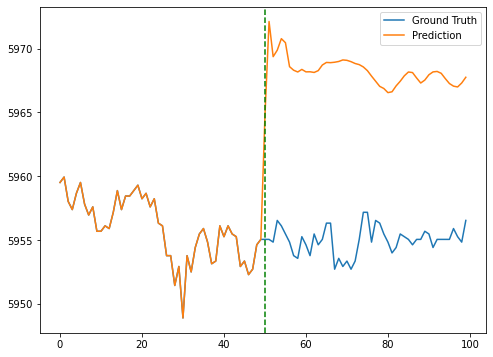

In [ ]:
closingData = GetSingleStockDF()[1][:1000].values
# re scale data
y_ground = (y_ground * closingData.std()) + closingData.mean()
y_pred = (y_pred * closingData.std()) + closingData.mean()
# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_ground, label='Ground Truth')
ax.plot(y_pred, label='Prediction')
# plt add v line at 50
ax.axvline(50, color='green', linestyle='--')
ax.legend()
plt.show()

In [ ]:
closingData.mean(), closingData.var()


(102.27434, 15.725695564399999)

In [ ]:
# use pandas rolling windows to split up the data
data = GetDF()
data.rolling(window=50).mean()
data

Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\AppData\Local\Temp\ipykernel_16572\327577449.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['time'], dtype='object')
  data.rolling(window=50).mean()


,id,identifier,close,high,interest,low,open,time,volume
0,282624,15611,263.20,263.20,0.0,263.10,263.20,2021-09-06 10:34:00,1158.000000
1,282625,15611,263.00,263.10,0.0,263.00,263.10,2021-09-06 10:35:00,1745.000000
2,282626,15611,263.00,263.00,0.0,262.90,262.90,2021-09-06 10:36:00,240.000000
3,282627,15611,262.90,262.90,0.0,262.90,262.90,2021-09-06 10:37:00,7.000000
4,282628,15611,263.10,263.10,0.0,263.00,263.00,2021-09-06 10:38:00,223.000000
...,...,...,...,...,...,...,...,...,...
230560,448159,15611,103.20,103.40,0.0,103.16,103.32,2020-03-20 09:02:00,10224.999848
230561,448160,15611,103.12,103.16,0.0,102.96,103.16,2020-03-20 09:03:00,9834.999853
230562,448161,15611,102.80,103.04,0.0,102.80,103.04,2020-03-20 09:04:00,11964.999822
230563,448162,15611,102.20,102.76,0.0,102.12,102.76,2020-03-20 09:05:00,14229.999788


In [ ]:
enc_outputs = torch.rand(n_step, batch_size, n_hidden)
dec_outputs = torch.rand(n_step, batch_size, n_hidden)
enc_outputs = enc_outputs.transpose(0, 1)
dec_outputs = dec_outputs.transpose(0, 1)
enc_outputs.shape, dec_outputs.shape

(torch.Size([32, 50, 128]), torch.Size([32, 50, 128]))

In [ ]:
enc_outputs = torch.nn.functional.linear(enc_outputs, torch.rand(n_hidden, n_hidden))
enc_outputs.shape

torch.Size([32, 50, 128])

In [ ]:
enc_outputs = enc_outputs.transpose(1,2)
dec_outputs.shape, enc_outputs.shape

(torch.Size([32, 50, 128]), torch.Size([32, 128, 50]))

In [ ]:
attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs), dim=-1)
attention_weights.shape, enc_outputs.shape
enc_outputs = enc_outputs.transpose(1,2)
torch.bmm(attention_weights, enc_outputs).shape

torch.Size([32, 50, 128])

In [ ]:
input_batch.unsqueeze(-1).shape

torch.Size([19802, 50, 1, 1])

In [ ]:
output_batch == target_batch

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]])